In [1]:
import torch, torchvision
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

import matplotlib.pyplot as plt
import os

b:\Programas\Anaconda\envs\detectron2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "../DatasetMouse/Computer mouse/train/_annotations.coco.json", "../DatasetMouse/Computer mouse/train")
register_coco_instances("my_dataset_val", {}, "../DatasetMouse/Computer mouse/valid/_annotations.coco.json", "../DatasetMouse/Computer mouse/valid")
register_coco_instances("my_dataset_test", {}, "../DatasetMouse/Computer mouse/test/_annotations.coco.json", "../DatasetMouse/Computer mouse/test")

WARNING [01/30 00:25:01 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/30 00:25:01 d2.data.datasets.coco]: Loaded 140 images in COCO format from ../DatasetMouse/Computer mouse/train/_annotations.coco.json


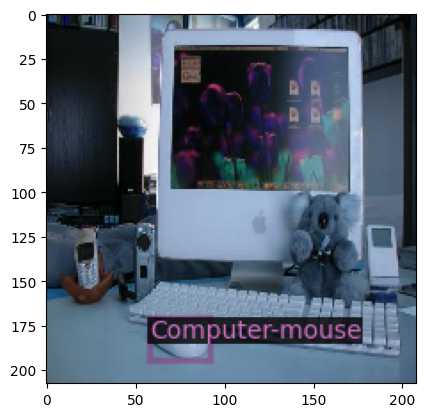

In [3]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])

In [4]:
#We are importing our own Trainer Module here to use the COCO validation evaluation during training. Otherwise no validation eval occurs.

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [5]:
#from .detectron2.tools.train_net import Trainer
#from detectron2.engine import DefaultTrainer
# select from modelzoo here: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines

from detectron2.config import get_cfg
#from detectron2.evaluation.coco_evaluation import COCOEvaluator
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001

cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 2000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2 #your number of classes + 1

cfg.TEST.EVAL_PERIOD = 500

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[01/30 00:25:12 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[01/30 00:25:12 d2.engine.train_loop]: Starting training from iteration 0


b:\Programas\Anaconda\envs\detectron2\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[01/30 00:34:01 d2.utils.events]:  eta: 16:12:38  iter: 19  total_loss: 1.981  loss_cls: 1.082  loss_box_reg: 0.8761  loss_rpn_cls: 0.008812  loss_rpn_loc: 0.002322    time: 27.8620  last_time: 28.3776  data_time: 0.1322  last_data_time: 0.0013   lr: 1.931e-06  max_mem: 4213M
[01/30 00:42:36 d2.utils.events]:  eta: 15:46:00  iter: 39  total_loss: 2.04  loss_cls: 1.077  loss_box_reg: 0.923  loss_rpn_cls: 0.004665  loss_rpn_loc: 0.002521    time: 26.7297  last_time: 20.4940  data_time: 0.0015  last_data_time: 0.0015   lr: 2.911e-06  max_mem: 4213M
[01/30 00:51:38 d2.utils.events]:  eta: 15:30:20  iter: 59  total_loss: 1.971  loss_cls: 1.014  loss_box_reg: 0.9402  loss_rpn_cls: 0.002902  loss_rpn_loc: 0.002752    time: 26.8678  last_time: 33.4925  data_time: 0.0015  last_data_time: 0.0013   lr: 3.891e-06  max_mem: 4213M
[01/30 01:00:29 d2.utils.events]:  eta: 15:20:45  iter: 79  total_loss: 1.859  loss_cls: 0.946  loss_box_reg: 0.9177  loss_rpn_cls: 0.002771  loss_rpn_loc: 0.003309    tim

In [6]:
%load_ext tensorboard
%tensorboard --logdir output

Reusing TensorBoard on port 6006 (pid 15604), started 1 day, 12:34:10 ago. (Use '!kill 15604' to kill it.)

In [7]:
#test evaluation
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

[01/30 14:14:58 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output\model_final.pth ...
[01/30 14:14:58 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [01/30 14:14:58 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [01/30 14:14:58 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/30 14:14:58 d2.data.datasets.coco]: Loaded 20 images in COCO format from ../DatasetMouse/Computer mouse/test/_annotations.coco.json
[01/30 14:14:58 d2.data.build]: Distribution of instances among all 2 categories:
|   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|
| Computer-mo.. | 0            | Computer-mo.. | 22           |
|               |              |               |  

OrderedDict([('bbox',
              {'AP': 67.64435456108127,
               'AP50': 81.84854243938327,
               'AP75': 71.96717040125066,
               'APs': 16.666666666666664,
               'APm': 55.709570957095714,
               'APl': 79.15686274509804,
               'AP-Computer-mouse': 67.64435456108127})])

In [8]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("my_dataset_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")

[01/30 14:15:19 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output\model_final.pth ...


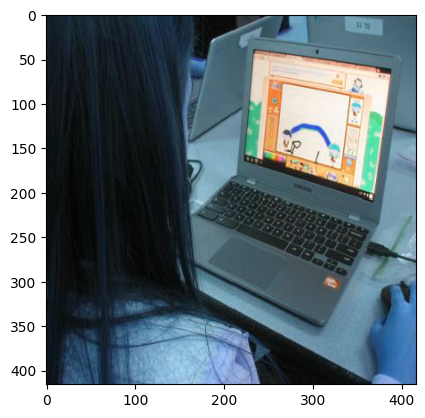

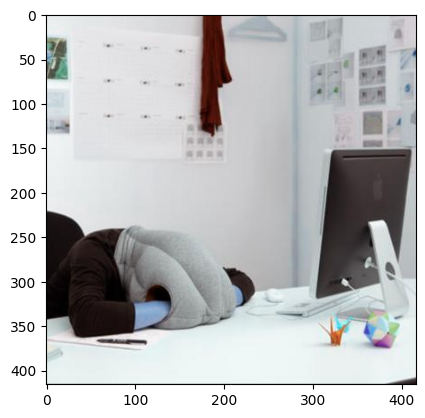

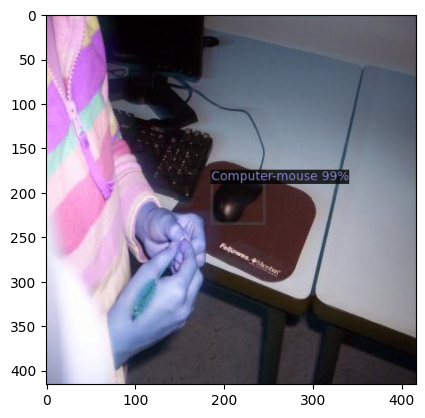

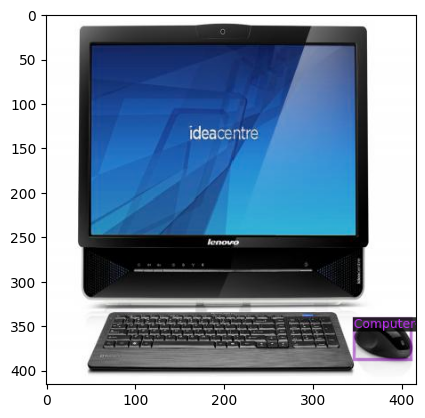

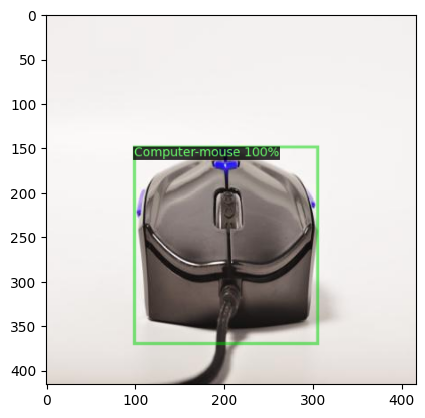

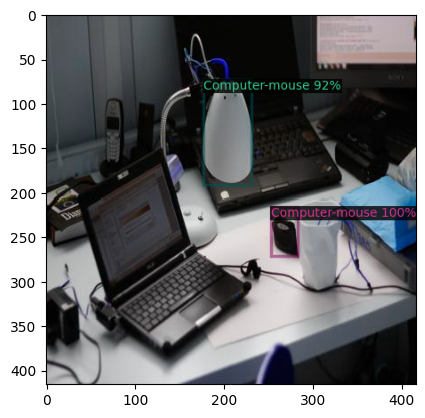

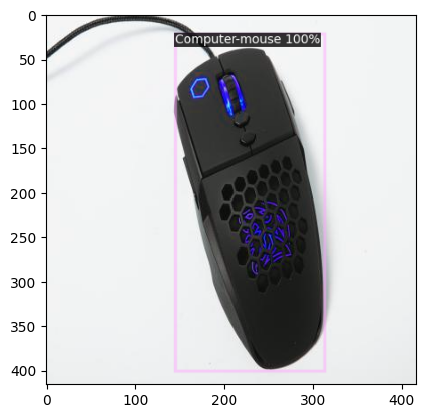

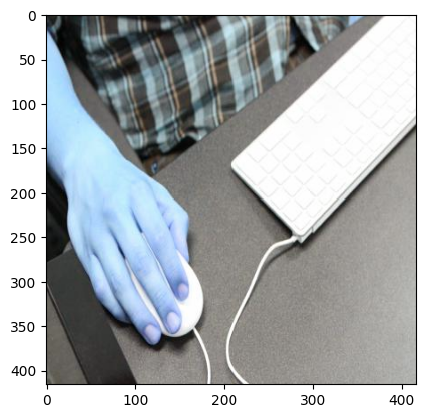

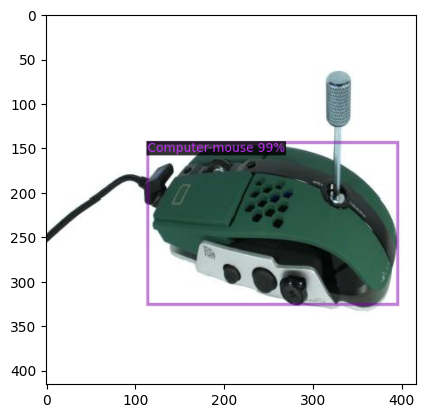

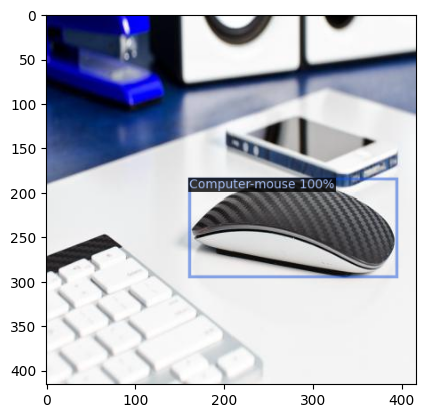

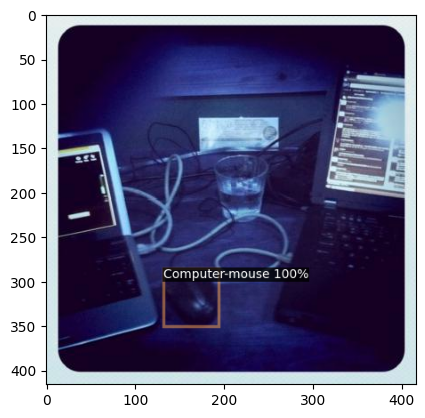

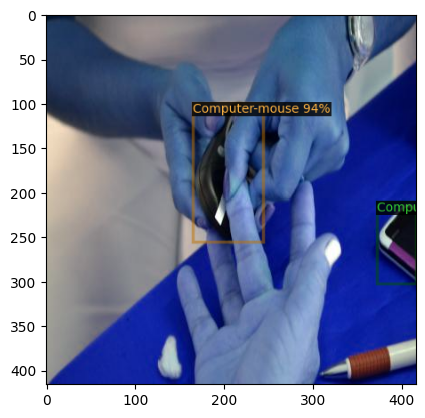

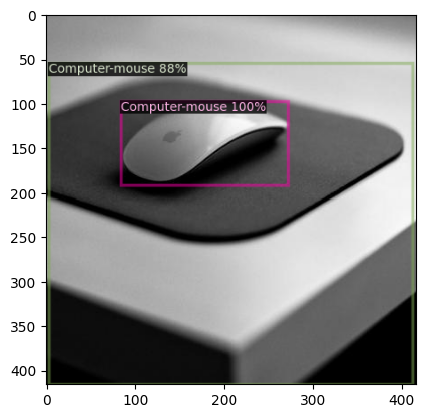

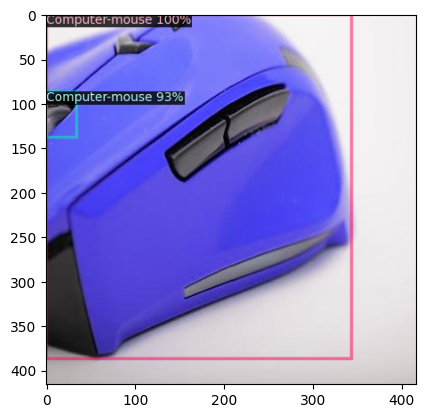

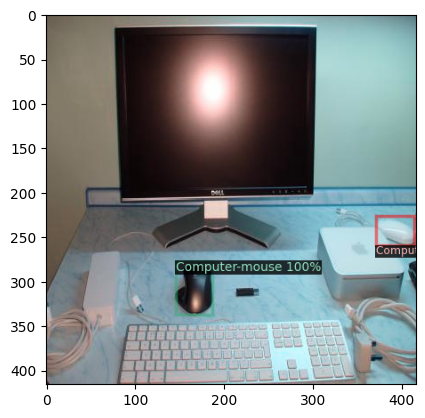

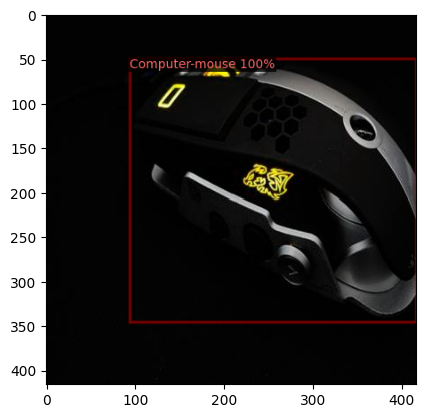

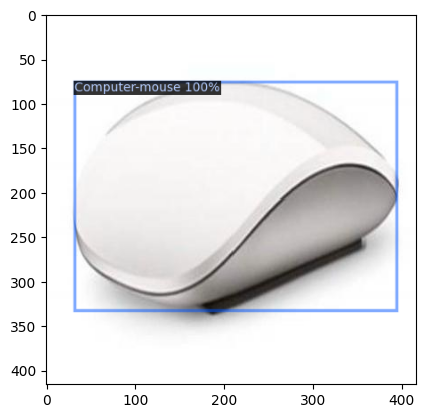

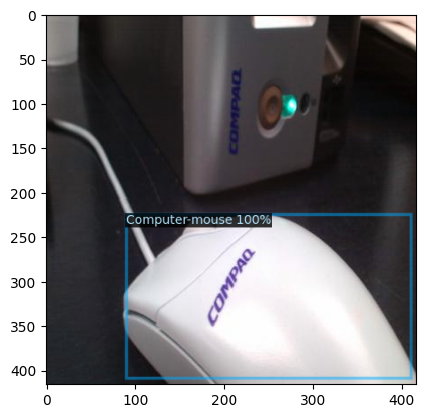

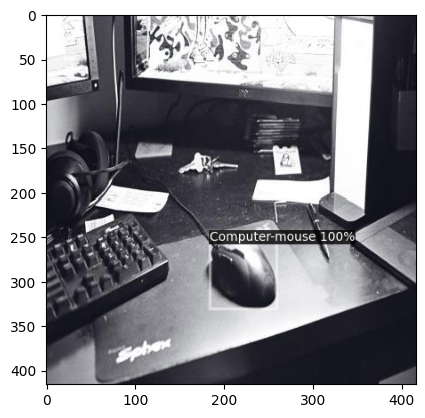

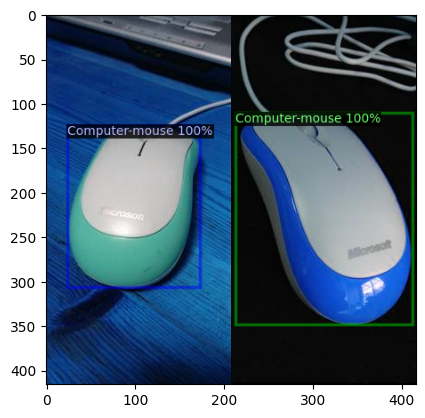

In [9]:
from detectron2.utils.visualizer import ColorMode
import glob
import matplotlib.pyplot as plt
import numpy as np

for imageName in glob.glob('../DatasetMouse/Computer mouse/test/*jpg'):
    im = cv2.imread(imageName)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata,
                   scale=1
                  )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    # Garante que a imagem está no formato C-contíguo
    img_array = np.ascontiguousarray(out.get_image()[:, :, ::-1])
    
    # Exibir a imagem dentro do loop usando plt.imshow()
    plt.imshow(img_array)
    plt.show()